In [107]:
import numpy as np
import json
import requests
import kagglehub
import os
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.src.applications.densenet import DenseNet121, preprocess_input
from keras.src.models import Sequential
from keras.src.utils import image_dataset_from_directory
from keras import layers, models
from keras.src.layers import Dense, Dropout

import matplotlib.pyplot as plt
import pandas as pd



from PIL import Image, ImageOps

from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing import image_dataset_from_directory
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.models import Model, Sequential



In [108]:
import kagglehub

path = kagglehub.dataset_download("rogerkoala/first-gen-pokemon")

In [109]:
os.listdir(path)

['pokemons_gen1.csv', 'dataset']

In [110]:
data_dir = f"{path}{os.sep}dataset"


In [111]:
train_dataset = image_dataset_from_directory(
    data_dir + os.sep + "train",
    image_size=(224,224 ),  # Resize images
    batch_size=32,
    label_mode="categorical"

)

test_dataset = image_dataset_from_directory(
    data_dir + os.sep + "test",
    image_size=(224,224),
    batch_size=32,
    label_mode="categorical"
)


Found 2249 files belonging to 151 classes.
Found 840 files belonging to 151 classes.


In [112]:
class_names = test_dataset.class_names #seznam tříd/názvů jednotlivých kategorií, odvozenych z názvů složek při načítání datasetu


In [113]:
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y))





In [114]:
# vytvoreni konvoluční neuronove síťe pro klasifikaci obrázků pomocí transfer learningu s předtrénovaným modelem RESNET101
# model využívá předtrénovaný základ ResNet01 pro extrakci vizuálních rysů a staví na něm vlastní klasifikátor pro nový úkol s 151 kategoriemi/pokemony

from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


num_classes = len(class_names)

base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


model.summary()



Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 42,939,927 (163.80 MB)

 Trainable params: 42,834,583 (163.40 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [115]:
#priprava modelu na trenovani

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




In [116]:
# ukládá checkpointu díky checkpoint_callback (např. nejlepší váhy modelu).

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    'soubor.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [117]:
# Trénování
#model.fit(train_dataset, epochs=100, validation_data=validation_generator)


epoch_val = 100

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epoch_val,
    callbacks=[checkpoint_callback]
)




Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.0427 - loss: 4.9742
Epoch 1: val_accuracy improved from -inf to 0.00595, saving model to soubor.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.0426 - loss: 4.9734 - val_accuracy: 0.0060 - val_loss: 629.0682
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.0709 - loss: 4.4369
Epoch 2: val_accuracy improved from 0.00595 to 0.00833, saving model to soubor.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 46s 647ms/step - accuracy: 0.0712 - loss: 4.4343 - val_accuracy: 0.0083 - val_loss: 7.8973
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.2213 - loss: 3.3348
Epoch 3: val_accuracy did not improve from 0.00833
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 580ms/step - accuracy: 0.2219 - loss: 3.3310 - val_accuracy: 0.0060 - val_loss: 6.6786
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.4114 - loss: 2.3577
Epoch 4: val_accuracy did not improve from 0.00833
71/71 ━━━━━━━━━━━━━━━━━━━━ 42

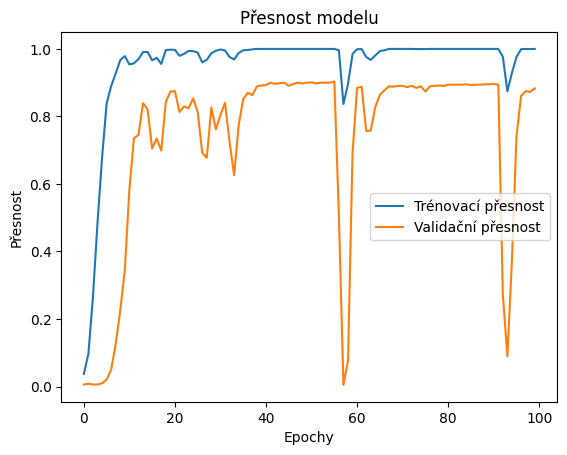

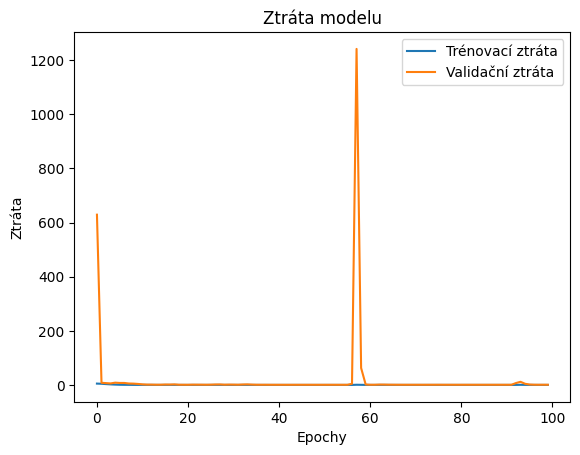

In [118]:
import matplotlib.pyplot as plt

# Přesnost
plt.plot(history.history['accuracy'], label='Trénovací přesnost')
plt.plot(history.history['val_accuracy'], label='Validační přesnost')
plt.legend()
plt.title('Přesnost modelu')
plt.xlabel('Epochy')
plt.ylabel('Přesnost')
plt.show()

# Ztráta
plt.plot(history.history['loss'], label='Trénovací ztráta')
plt.plot(history.history['val_loss'], label='Validační ztráta')
plt.legend()
plt.title('Ztráta modelu')
plt.xlabel('Epochy')
plt.ylabel('Ztráta')
plt.show()

In [120]:
saved_model_Resnet = keras.saving.load_model("soubor.keras")

In [162]:
#stazeni modelu na lokalni disk
from IPython.display import FileLink
FileLink(r'soubor.keras')  # nahraď názvem svého souboru

/kaggle/working/soubor.keras

In [121]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))         # skutečné třídy
    y_pred.extend(np.argmax(preds, axis=1))                   # predikované třídy

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

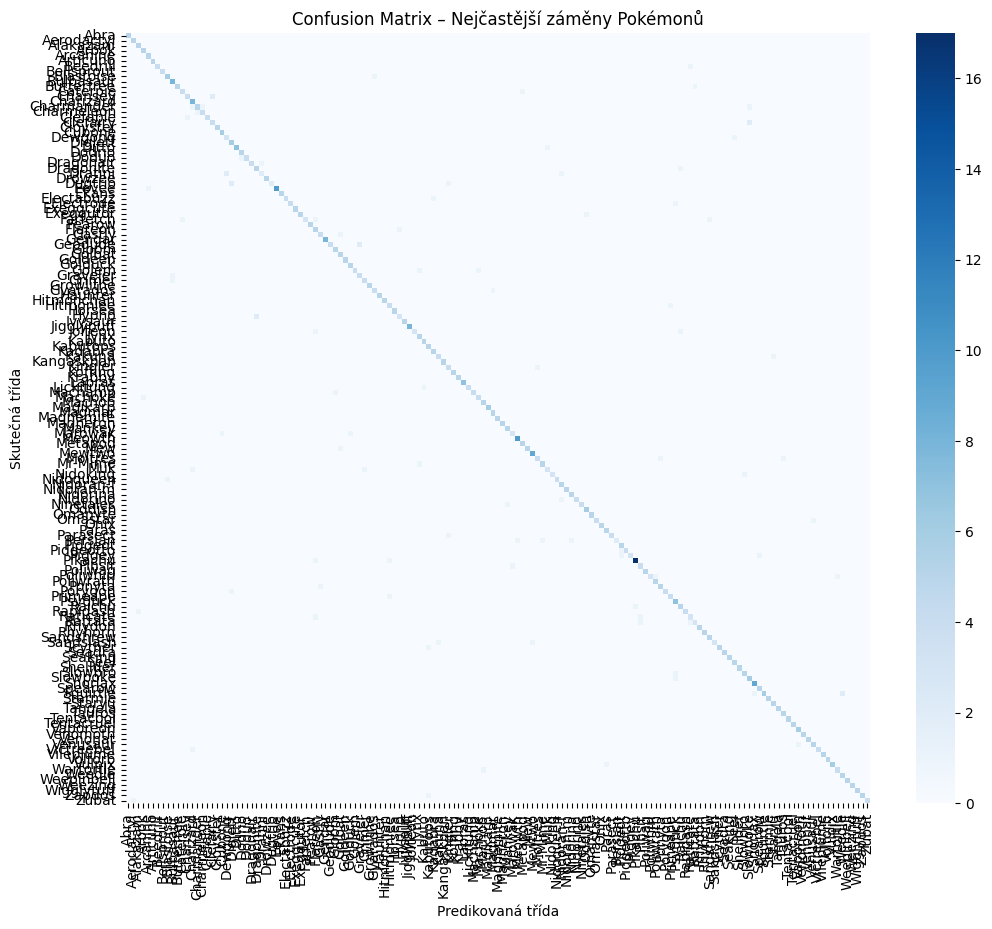

In [122]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predikovaná třída')
plt.ylabel('Skutečná třída')
plt.title('Confusion Matrix – Nejčastější záměny Pokémonů')
plt.show()

In [152]:
#TOP 10 nejcastejsich zamen - Confusion matrix
import pandas as pd

cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
most_confused = cm_df.stack().sort_values(ascending=False)
most_confused = most_confused[most_confused.index.get_level_values(0) != most_confused.index.get_level_values(1)]
print("Top 10 nejčastějších záměn:")
print(most_confused.head(10))

Top 10 nejčastějších záměn:
Hypno       Dragonite    2
Geodude     Graveler     2
Clefairy    Slowpoke     2
Squirtle    Weedle       2
Chansey     Clefairy     2
Dratini     Dewgong      2
Dugtrio     Diglett      2
Rattata     Pinsir       1
Electabuzz  Kadabra      1
Kingler     Moltres      1
dtype: int64


In [153]:


import random
import matplotlib.pyplot as plt

def show_comparison(wrong_img, correct_img, true_label, pred_label):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    for ax, img, title in zip(axes, [wrong_img, correct_img], [f"Predikce: {pred_label}", f"Správně: {true_label}"]):
        if img.dtype != np.uint8:
            img = (img - np.min(img)) / (np.max(img) - np.min(img))
            img = (img * 255).astype("uint8")
        ax.imshow(img)
        ax.set_title(title, fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

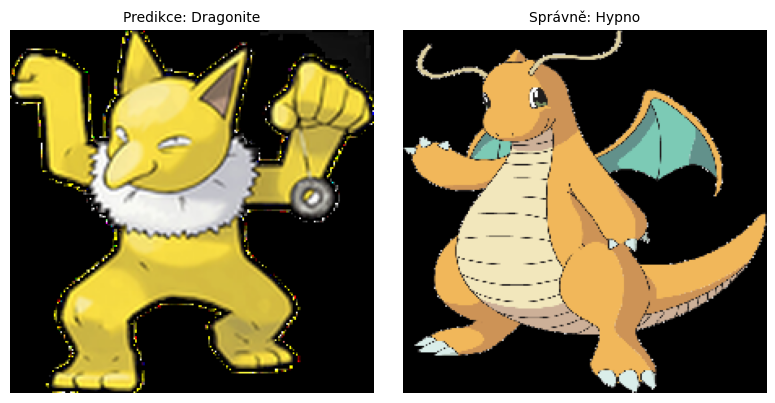

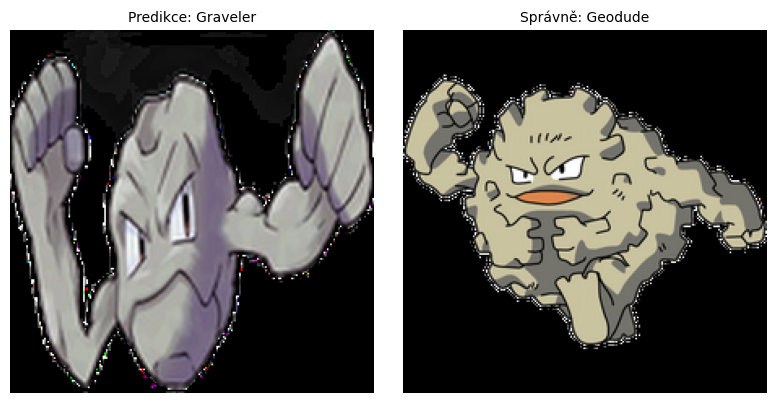

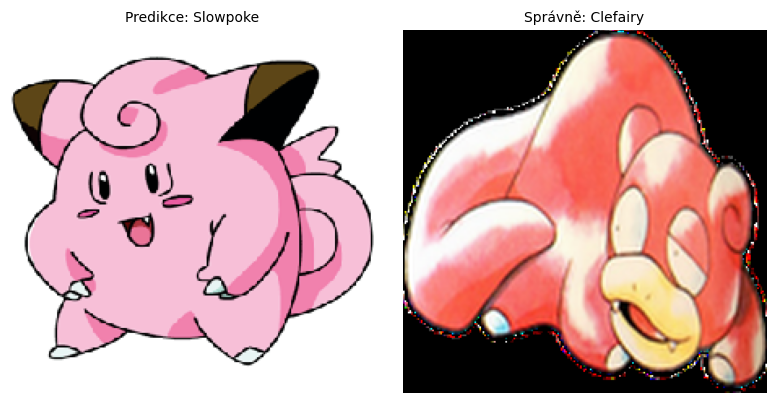

In [161]:
# Zobraz top3 záměn jako dvojice obrázk

shown = 0

for (true_cls, pred_cls), count in most_confused.items():
    true_idx = class_names.index(true_cls)
    pred_idx = class_names.index(pred_cls)

    # Najdi špatně klasifikovaný obrázek
    wrong_img = None
    for i in range(len(y_true)):
        if y_true[i] == true_idx and y_pred[i] == pred_idx:
            wrong_img = images_list[i]
            break

    # Najdi správně klasifikovaný obrázek z predikované třídy
    correct_img = None
    for i in range(len(y_true)):
        if y_true[i] == pred_idx and y_pred[i] == pred_idx:
            correct_img = images_list[i]
            break

    # Pokud máme obě varianty, zobrazíme je
    if wrong_img is not None and correct_img is not None:
        show_comparison(wrong_img, correct_img, true_cls, pred_cls)
        shown += 1

    if shown >= 3:
        break